In [17]:
import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from scipy import stats

from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian2DKernel

from tqdm import tqdm
import integratedflux as flux
import warnings
from astropy.utils.exceptions import AstropyWarning

In [69]:
path = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/'
fname = 'Abell_85_Linpol_Freqmean'
hdu = fits.open(get_pkg_data_filename(path+fname+'.fits'))[0]
header = hdu.header
data = hdu.data

warnings.filterwarnings('ignore', category=AstropyWarning, append=True)
mask_sources = flux.mask_regions(path+'Abell85_ch0_BDSF.fits','/net/vdesk/data2/GoesaertW/Data_Analyis_Git/Abell85_catalog_BDSF_adapbox_rsl.reg','mask_sources_adaprms.fits',maskoutside=False)[0][0]
#mask_sources = np.load('testmask.npy')

[ 1.3586112e-05  2.1158334e-05  3.2536311e-05 ... -2.6752430e-05
 -3.2999491e-05 -3.9872823e-05]
Writing mask file to mask_sources_adaprms.fits


In [45]:
def background_convolver(data_local, sourcemask, kernal_std=10, kernal_size=51, task=[True, True, True]):
    data_masked = ma.masked_array(data_local, mask = sourcemask)
    data_masked_nan = np.where(data_masked.mask,np.nan,data_masked)
    
    kernel = Gaussian2DKernel(x_stddev=kernal_std, x_size=kernal_size, y_size=kernal_size)
    
    output = []
    
    if task[0]:
        mean = convolve(data_masked_nan, kernel, boundary='extend')
        output.append(mean)
    if task[1]:
        rms = np.sqrt(convolve(data_masked_nan**2, kernel, boundary='extend'))
        output.append(rms)
    if task[2]:
        std = np.sqrt(convolve((data_masked_nan-mean)**2, kernel, boundary='extend'))
        output.append(std)

    return output

In [46]:
mean, rms, std = background_convolver(data, mask_sources)

2.4956975e-05
2.49575e-05
2.4777335e-05
2.5167421e-05


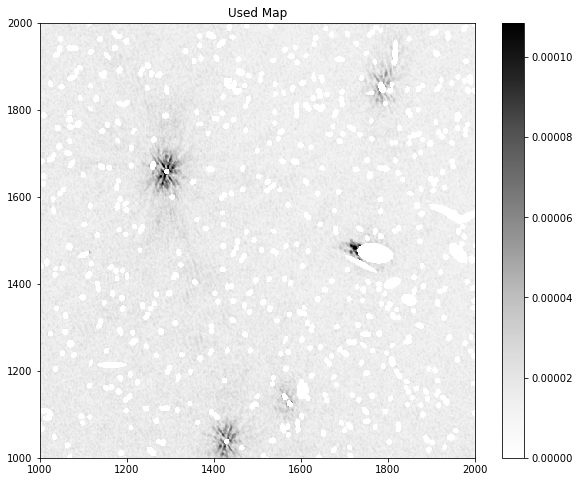

In [44]:
data_masked = ma.masked_array(data, mask = mask_sources)
data_masked_nan = np.where(data_masked.mask,np.nan,data_masked)

print(np.nanmean(data))
print(np.nanmean(data_masked_nan))
print(np.nanmean(mean))
print(np.nanmean(rms))

plt.figure(figsize=(10,8))
plt.title('Used Map')
plt.imshow(data_masked, vmin=0, vmax=0.01*np.max(data), cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlim(1000,2000)
plt.ylim(1000,2000)
plt.show()

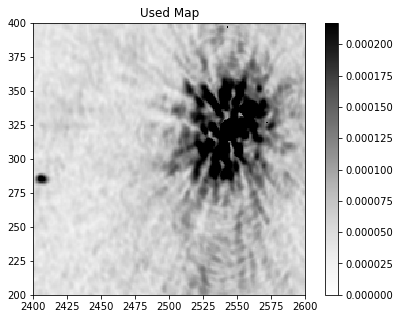

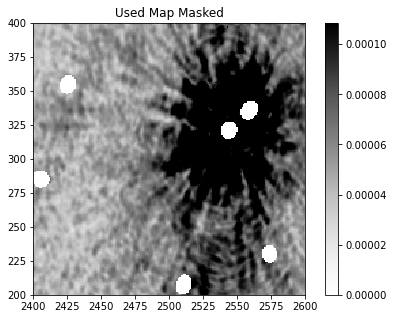

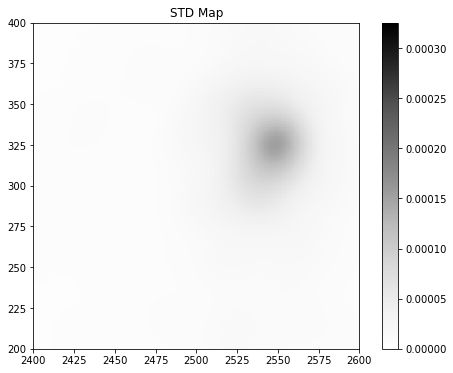

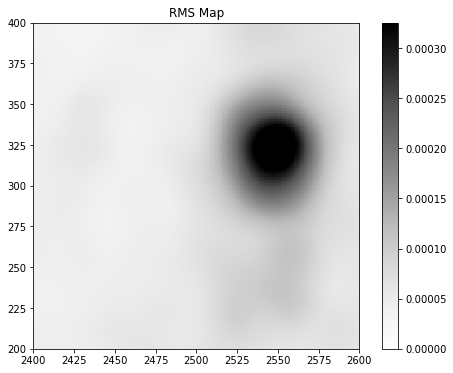

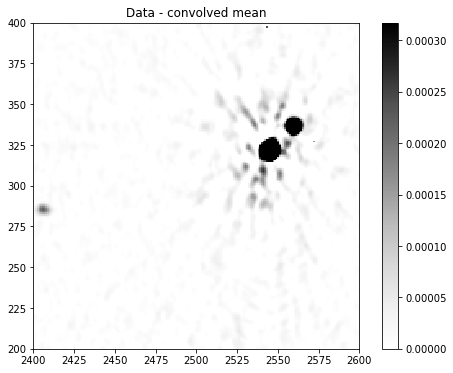

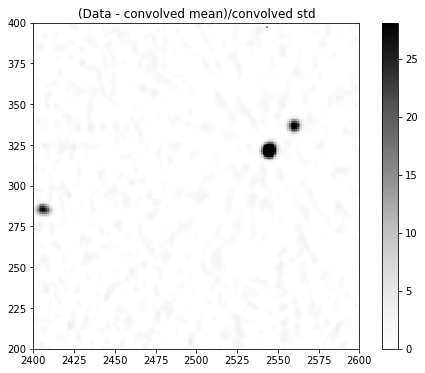

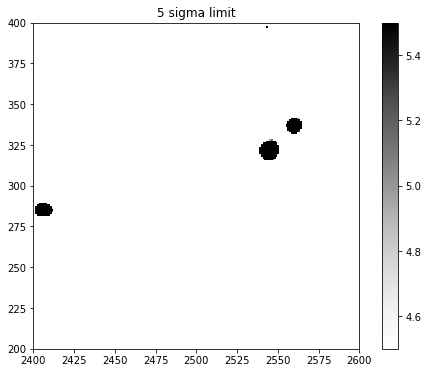

In [93]:
xlimits = (2400,2600)
ylimits = (200,400)

plt.figure(figsize=(7,5))
plt.title('Used Map')
plt.imshow(data, vmin=0, vmax=0.02*np.max(data), cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

plt.figure(figsize=(7,5))
plt.title('Used Map Masked')
plt.imshow(data_masked, vmin=0, vmax=0.01*np.max(data), cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

plt.figure(figsize=(8,6))
plt.title('STD Map')
plt.imshow(std, vmin=0, vmax=0.03*np.max(data), cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

plt.figure(figsize=(8,6))
plt.title('RMS Map')
plt.imshow(rms, vmin=0, vmax=0.03*np.max(data), cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

plt.figure(figsize=(8,6))
plt.title('Data - convolved mean')
plt.imshow(data-mean, vmin=0, vmax=0.03*np.max(data-mean), cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

plt.figure(figsize=(8,6))
plt.title('(Data - convolved mean)/convolved std')
plt.imshow((data-mean)/std, vmin=0, vmax=0.2*np.max((data-mean)/std), cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

plt.figure(figsize=(8,6))
plt.title('5 sigma limit')
plt.imshow((data-mean)/std, vmin=5, vmax=5, cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlim(xlimits)
plt.ylim(ylimits)
plt.show()

In [56]:
directory = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/'
Sourcefind = data/rms
Sourcefind2 = data-mean
Fits_RMS = fits.PrimaryHDU(rms)
Fits_Mean = fits.PrimaryHDU(mean)
Fits_Data_RMS = fits.PrimaryHDU(data/rms) #Deze is nice! data/rms>2 geeft goede selectie!
Fits_Data_Mean = fits.PrimaryHDU(data-mean)
Fits_Data_Mean_Std = fits.PrimaryHDU((data-mean)/std)

Fits_RMS.writeto(directory+'Abell_85_Fits_RMS.fits', overwrite=True)
Fits_Mean.writeto(directory+'Abell_85_Fits_Mean.fits', overwrite=True)
Fits_Data_RMS.writeto(directory+'Abell_85_Fits_Data_RMS.fits', overwrite=True)
Fits_Data_Mean.writeto(directory+'Abell_85_Fits_Data_Mean.fits', overwrite=True)
Fits_Data_Mean_Std.writeto(directory+'Abell_85_Fits_Data_Mean_Std.fits', overwrite=True)

In [12]:
percentiles = np.percentile(Sourcefind2, [25, 50, 75])
median_tot = percentiles[1]
rms_tot = (percentiles[2] - percentiles[0])/(stats.norm.ppf(0.75) - stats.norm.ppf(0.25))
print(median_tot, rms_tot)
print(10*rms_tot)

-1.2532382243080065e-07 3.4654162505158814e-06
3.4654162505158815e-05


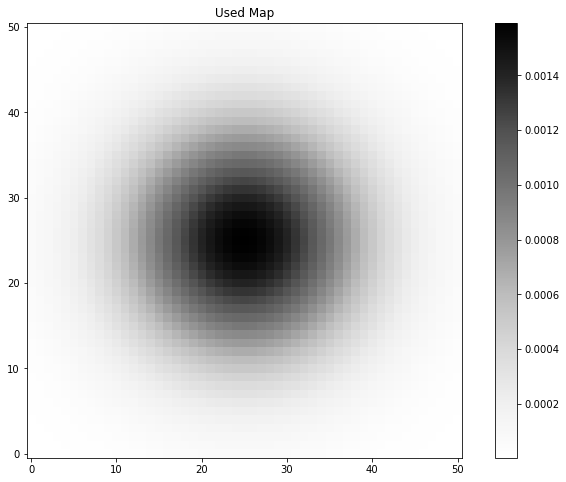

In [13]:
plt.figure(figsize=(12,8))
plt.title('Used Map')
plt.imshow(kernel, cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.show()

In [59]:
mask = np.array(((data-mean)/std >= 5), dtype=float)
Fits_mask = fits.PrimaryHDU(mask)

Fits_mask.writeto(directory+'Abell_85_Linpolmask.fits', overwrite=True)

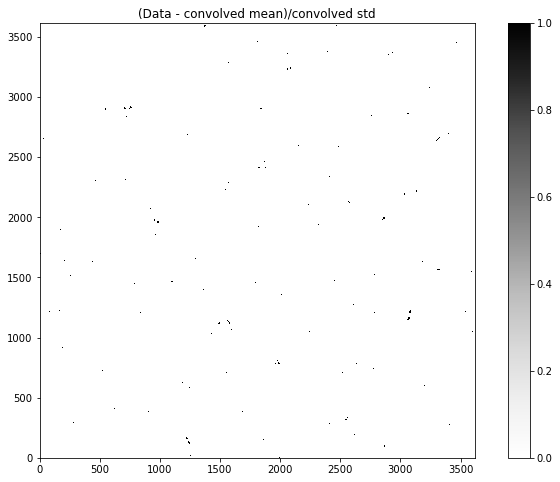

In [15]:
plt.figure(figsize=(12,8))
plt.title('(Data - convolved mean)/convolved std')
plt.imshow(mask, cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
#plt.xlim(500,1500)
#plt.ylim(1500, 2500)
plt.savefig('linpol_selection.pdf', dpi=500)

# Calculating RMS maps:

In [60]:
task_RMS = [False, True, False] #Calculate only the rms over each image

#mask_sources = np.load('testmask.npy')

directory_univ_I = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/I_slices/'
directory_univ_Q = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/Q_slices/'
directory_univ_U = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/U_slices/'

for i in tqdm(range(12)):
    hdul_image = fits.open(directory_univ_I+'Abell_85_I_plane_freq'+(2-len(str((i+1))))*'0' + str(i+1)+'.fits')
    data_image = hdul_image[0].data.squeeze()
    
    rms = background_convolver(data_image, mask_sources, task=task_RMS)[0]
    
    rms_cube = np.zeros((1,1,3617,3617))
    rms_cube[0,0,:,:] = rms
    hdu_rms = fits.PrimaryHDU(rms_cube)
    hdu_rms.header = hdul_image[0].header
    hdu_rms.writeto(directory_univ_I+'Abell_85_I_RMS_plane_freq'+(2-len(str((i+1))))*'0' + str(i+1)+'.fits', overwrite=True)
    hdul_image.close()
    
print('I is done.')

for i in tqdm(range(12)):
    hdul_image = fits.open(directory_univ_Q+'Abell_85_Q_plane_freq'+(2-len(str((i+1))))*'0' + str(i+1)+'.fits')
    data_image = hdul_image[0].data.squeeze()
    
    rms = background_convolver(data_image, mask_sources, task=task_RMS)[0]
    
    rms_cube = np.zeros((1,1,3617,3617))
    rms_cube[0,0,:,:] = rms
    hdu_rms = fits.PrimaryHDU(rms_cube)
    hdu_rms.header = hdul_image[0].header
    hdu_rms.writeto(directory_univ_Q+'Abell_85_Q_RMS_plane_freq'+(2-len(str((i+1))))*'0' + str(i+1)+'.fits', overwrite=True)
    hdul_image.close()
    
print('Q is done.')

for i in tqdm(range(12)):
    hdul_image = fits.open(directory_univ_U+'Abell_85_U_plane_freq'+(2-len(str((i+1))))*'0' + str(i+1)+'.fits')
    data_image = hdul_image[0].data.squeeze()
    
    rms = background_convolver(data_image, mask_sources, task=task_RMS)[0]
    
    rms_cube = np.zeros((1,1,3617,3617))
    rms_cube[0,0,:,:] = rms
    hdu_rms = fits.PrimaryHDU(rms_cube)
    hdu_rms.header = hdul_image[0].header
    hdu_rms.writeto(directory_univ_U+'Abell_85_U_RMS_plane_freq'+(2-len(str((i+1))))*'0' + str(i+1)+'.fits', overwrite=True)
    hdul_image.close()
    
print('U is done.')

100%|██████████| 12/12 [25:27<00:00, 127.33s/it]


I is done.


100%|██████████| 12/12 [24:39<00:00, 123.31s/it]


Q is done.


100%|██████████| 12/12 [24:17<00:00, 121.44s/it]

U is done.


# What if we work with Linpol from rmsynth instead?

In [83]:
path_rmsynth = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/rmsynth/'
fname_rmsynth = 'rmsynth_polint'
hdu_rmsynth = fits.open(get_pkg_data_filename(path_rmsynth+fname_rmsynth+'.fits'))[0]
header_rmsynth = hdu.header
data_rmsynth = hdu_rmsynth.data

#mask_sources = np.load('testmask.npy')
data_masked_rmsynth = ma.masked_array(data_rmsynth, mask = mask_sources)

In [85]:
data_masked_nan_rmsynth = np.where(data_masked_rmsynth.mask,np.nan,data_masked_rmsynth)
kernel_rmsynth = Gaussian2DKernel(x_stddev=10, x_size=51, y_size=51)
mean_rmsynth = convolve(data_masked_nan_rmsynth, kernel_rmsynth, boundary='extend')

rms_rmsynth = np.sqrt(convolve(data_masked_nan_rmsynth**2, kernel_rmsynth, boundary='extend'))

std_rmsynth = np.sqrt(convolve((data_masked_nan_rmsynth-mean_rmsynth)**2, kernel_rmsynth, boundary='extend'))

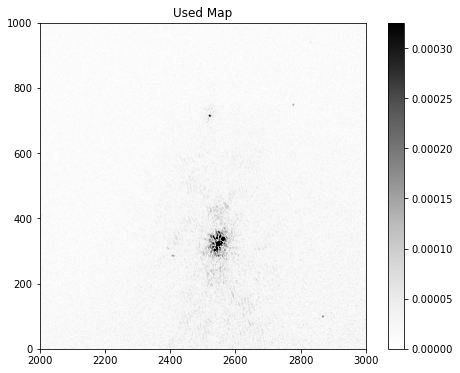

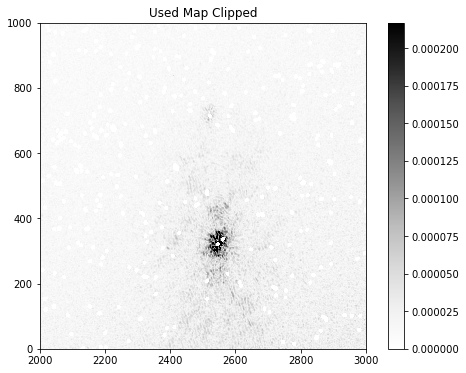

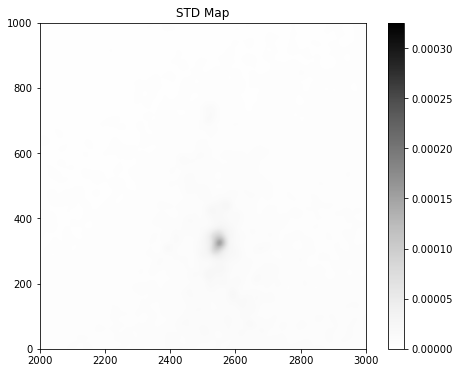

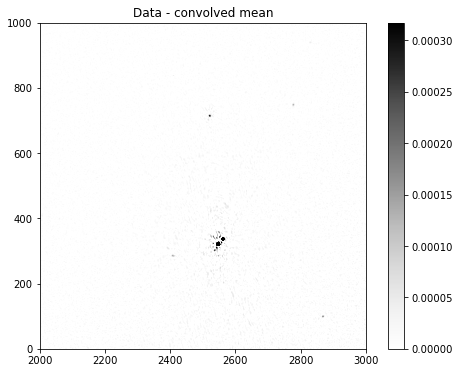

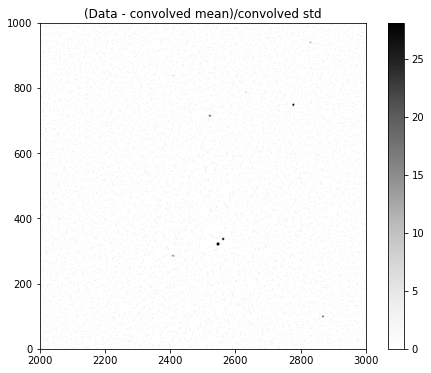

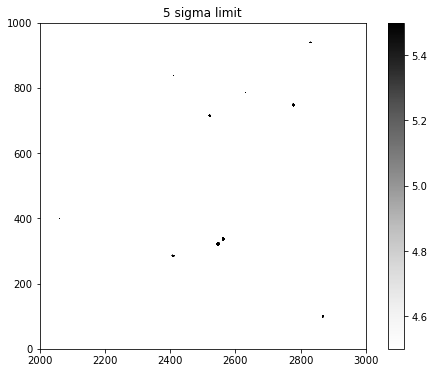

In [123]:
plt.figure(figsize=(8,6))
plt.title('Used Map')
plt.imshow(data_rmsynth, vmin=0, vmax=0.03*np.max(data), cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlim(2000,3000)
plt.ylim(0,1000)
plt.show()

plt.figure(figsize=(8,6))
plt.title('Used Map Clipped')
plt.imshow(data_masked_nan_rmsynth, cmap='Greys', origin='lower', vmin=0, vmax=0.02*np.max(data), interpolation='nearest')
plt.colorbar()
plt.xlim(2000,3000)
plt.ylim(0,1000)
plt.show()

plt.figure(figsize=(8,6))
plt.title('STD Map')
plt.imshow(std_rmsynth, vmin=0, vmax=0.03*np.max(data), cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlim(2000,3000)
plt.ylim(0,1000)
plt.show()

plt.figure(figsize=(8,6))
plt.title('Data - convolved mean')
plt.imshow(data_rmsynth-mean_rmsynth, vmin=0, vmax=0.03*np.max(data-mean), cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlim(2000,3000)
plt.ylim(0,1000)
plt.show()

plt.figure(figsize=(8,6))
plt.title('(Data - convolved mean)/convolved std')
plt.imshow((data_rmsynth-mean_rmsynth)/std_rmsynth, vmin=0, vmax=0.2*np.max((data-mean)/std), cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlim(2000,3000)
plt.ylim(0,1000)
plt.show()

plt.figure(figsize=(8,6))
plt.title('5 sigma limit')
plt.imshow((data_rmsynth-mean_rmsynth)/std_rmsynth, vmin=5, vmax=5, cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlim(2000,3000)
plt.ylim(0,1000)
plt.show()

In [124]:
directory = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/'

Fits_RMS_rmsynth = fits.PrimaryHDU(rms_rmsynth)
Fits_Mean_rmsynth = fits.PrimaryHDU(mean_rmsynth)
Fits_Data_RMS_rmsynth = fits.PrimaryHDU(data_rmsynth/rms_rmsynth) #Deze is nice! data/rms>2 geeft goede selectie!
Fits_Data_Mean_rmsynth = fits.PrimaryHDU(data_rmsynth-mean_rmsynth)
Fits_Data_Mean_Std_rmsynth = fits.PrimaryHDU((data_rmsynth-mean_rmsynth)/std_rmsynth)

Fits_RMS_rmsynth.writeto(directory+'Abell_85_Fits_RMS_rmsynth.fits', overwrite=True)
Fits_Mean_rmsynth.writeto(directory+'Abell_85_Fits_Mean_rmsynth.fits', overwrite=True)
Fits_Data_RMS_rmsynth.writeto(directory+'Abell_85_Fits_Data_RMS_rmsynth.fits', overwrite=True)
Fits_Data_Mean_rmsynth.writeto(directory+'Abell_85_Fits_Data_Mean_rmsynth.fits', overwrite=True)
Fits_Data_Mean_Std_rmsynth.writeto(directory+'Abell_85_Fits_Data_Mean_Std_rmsynth.fits', overwrite=True)